In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"D:\Fixed Paths 3\ICICI Minute Data.csv", index_col=0, parse_dates=True, dayfirst=True)
df

,Open,High,Low,Close,Volume
Time,,,,,
2018-02-22 09:15:59,319.25,319.40,316.05,317.70,143354
2018-02-22 09:16:59,317.70,318.20,317.70,318.00,52695
2018-02-22 09:17:59,318.00,318.85,318.00,318.55,47179
2018-02-22 09:18:59,318.65,319.40,318.50,319.20,44745
2018-02-22 09:19:59,319.30,319.85,319.20,319.65,57892
...,...,...,...,...,...
2018-02-23 15:25:59,321.80,321.95,321.75,321.80,38601
2018-02-23 15:26:59,321.85,321.85,321.45,321.55,61275
2018-02-23 15:27:59,321.60,321.75,321.35,321.45,65368


### Feature Engineering

#### All the indicators are created based on the 10 min timeframe

In [4]:
df['RSI'] = ta.RSI(df['Close'].shift(1), timeperiod=10)                # .shift(1) is used to avoid look ahead bias
df['SMA'] = df['Close'].shift(1).rolling(10).mean()
df['Corr'] = df['Close'].shift(1).rolling(10).corr(df['SMA'].shift(1))
df['SAR'] = ta.SAR(df['High'].shift(1), df['Low'].shift(1), 0.2, 0.2)
df['ADX'] = ta.ADX(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1), timeperiod=10)

Passing the previous minute's High, Low, and Close prices as input to the algorithm. This will help the algorithm sense the volatility of the past time period.

In [5]:
df['Prev_High'] = df['High'].shift(1)
df['Prev_Low'] = df['Low'].shift(1)
df['Prev_Close'] = df['Close'].shift(1)

Creating two more features based on Open

In [6]:
df['OO'] = df['Open'] - df['Open'].shift(1)
df['OC'] = df['Open'] - df['Close'].shift(1)
df

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,Prev_High,Prev_Low,Prev_Close,OO,OC
Time,,,,,,,,,,,,,,,
2018-02-22 09:15:59,319.25,319.40,316.05,317.70,143354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-22 09:16:59,317.70,318.20,317.70,318.00,52695,NaN,NaN,NaN,NaN,NaN,319.40,316.05,317.70,-1.55,0.00
2018-02-22 09:17:59,318.00,318.85,318.00,318.55,47179,NaN,NaN,NaN,316.0500,NaN,318.20,317.70,318.00,0.30,0.00
2018-02-22 09:18:59,318.65,319.40,318.50,319.20,44745,NaN,NaN,NaN,316.4800,NaN,318.85,318.00,318.55,0.65,0.10
2018-02-22 09:19:59,319.30,319.85,319.20,319.65,57892,NaN,NaN,NaN,316.9540,NaN,319.40,318.50,319.20,0.65,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-23 15:25:59,321.80,321.95,321.75,321.80,38601,68.057161,321.495,0.619122,321.4540,22.674351,321.95,321.70,321.80,-0.05,0.00
2018-02-23 15:26:59,321.85,321.85,321.45,321.55,61275,68.057161,321.560,0.717711,321.5532,23.107498,321.95,321.75,321.80,0.05,0.05
2018-02-23 15:27:59,321.60,321.75,321.35,321.45,65368,51.760292,321.595,0.500653,321.9500,21.483583,321.85,321.45,321.55,-0.25,0.05


Calculate returns for each data point. And save the returns for the past 10 minutes in columns named "return1", "return2", and so on. This helps the algorithm understand return trends over the last 10 periods.

In [33]:
df['fut_rets'] = ((df['Open'].shift(-1) - df['Open']) / df['Open'])

for i in range(1, 10):
    df[f'Pct_change{i}'] = df['fut_rets'].shift(i)

df.tail()

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,...,Pct_change6,Pct_change7,Pct_change8,Pct_change9,Signal,Pred_Signal,strategy_returns,cum_rets,peak,drawdown
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-23 15:24:59,321.85,321.95,321.70,321.80,57039,71.715070,321.415,0.207479,321.3300,22.193076,...,0.001245,0.000000,0.000311,0.000156,0,1.0,-0.000155,1.013631,1.013789,-0.000157
2018-02-23 15:25:59,321.80,321.95,321.75,321.80,38601,68.057161,321.495,0.619122,321.4540,22.674351,...,0.000155,0.001245,0.000000,0.000311,0,0.0,0.000000,1.013631,1.013789,-0.000157
2018-02-23 15:26:59,321.85,321.85,321.45,321.55,61275,68.057161,321.560,0.717711,321.5532,23.107498,...,-0.000466,0.000155,0.001245,0.000000,-1,-1.0,0.000777,1.014419,1.014419,0.000000
2018-02-23 15:27:59,321.60,321.75,321.35,321.45,65368,51.760292,321.595,0.500653,321.9500,21.483583,...,0.000000,-0.000466,0.000155,0.001245,-1,-1.0,0.000466,1.014892,1.014892,0.000000
2018-02-23 15:28:59,321.45,321.80,321.25,321.25,132081,46.781521,321.620,0.123520,321.9500,20.859332,...,0.000622,0.000000,-0.000466,0.000155,-1,0.0,-0.000000,1.014892,1.014892,0.000000


In [34]:
df.dropna(inplace=True)

### Train & Test data

In [35]:
split = int(len(df)*0.8)
split

116

## Create output signals

For assigning signal values corresponding to returns, splitting the data into three equal parts.

1. Highest returns’ quantile is assigned 1
2. Middle quantile is assigned 0
3. Lowest quantile is assigned -1 

In [10]:
# Calculate quantiles for the training data
high_quantile = df['fut_rets'][:split].quantile(0.66)
low_quantile = df['fut_rets'][:split].quantile(0.34)

# Create 'Signal' column and assign values using np.where
df['Signal'] = 0
df['Signal'] = np.where(df['fut_rets'] > high_quantile, 1, df['Signal'])
df['Signal'] = np.where(df['fut_rets'] < low_quantile, -1, df['Signal'])

df

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,...,Pct_change1,Pct_change2,Pct_change3,Pct_change4,Pct_change5,Pct_change6,Pct_change7,Pct_change8,Pct_change9,Signal
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-22 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,0.816229,319.184400,13.793519,...,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,0.002199,-1
2018-02-22 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,0.871812,318.917520,15.563131,...,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,-1
2018-02-22 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,0.919286,318.654016,17.581703,...,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,1
2018-02-22 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,0.892114,318.403213,18.123915,...,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,1
2018-02-22 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,0.616495,317.250000,16.790058,...,0.001886,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-23 15:24:59,321.85,321.95,321.70,321.80,57039,71.715070,321.415,0.207479,321.330000,22.193076,...,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0.000156,0
2018-02-23 15:25:59,321.80,321.95,321.75,321.80,38601,68.057161,321.495,0.619122,321.454000,22.674351,...,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0
2018-02-23 15:26:59,321.85,321.85,321.45,321.55,61275,68.057161,321.560,0.717711,321.553200,23.107498,...,0.000155,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,-1


Since this is an intraday strategy, close all positions at the end of the day by setting the Signal and Fut_Ret columns to 0 at closing time.

In [11]:
df.loc[(df.index.hour == 15) & (df.index.minute == 29), 'Signal'] = 0
df.loc[(df.index.hour == 15) & (df.index.minute == 29), 'fut_rets'] = 0

### Creating the features and values

In [12]:
X = df.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'fut_rets'], axis=1)
y = df['Signal']

## Find the best parameters

### Pipeline and functions

In [13]:
# steps = [('scaler', StandardScaler()), ('SVC', SVC())]
steps = [('scaler', StandardScaler()), ('svc', SVC())]
pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

### Hyperparameters

Will choose 4 test values for `c` [Regularization] and 3 test values for `g` [Gamma].  

In [14]:
c = [10, 100, 1000, 10000]
g = [1e-2, 1e-1, 1e0]

In [15]:
parameters = {'svc__C': c, 'svc__gamma': g, 'svc__kernel': ['rbf']}         # Intialise the parameters

Now, created a **RandomizedSearchCV** function with a **TimeSeriesSplit** object with a **n_split** value of 2. 

In [16]:
rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))

### Training on and fetching the best parameters

In [36]:
rcv.fit(X.iloc[:split], y.iloc[:split])              # calling "fit" method 

best_C = rcv.best_params_['svc__C']                  # Best regularization/C paramter

best_gamma = rcv.best_params_['svc__gamma']          # Best gamma paramter

best_kernel = rcv.best_params_['svc__kernel']        # Best kernel function

### Create the SVM with best hyperparamters

In [37]:
svm = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)

### Train the data

Earlier `fit` Method`(rcv.fit)`: Fits the entire pipeline (including `StandardScaler` and `SVC`) within the `RandomizedSearchCV` to get the best hyperparameters: C, gamma & kernel

After obtaining the best hyperparameters, you're training a standalone SVC model (svm) with those parameters. This is a separate model training step.

The scaling here is performed explicitly with StandardScaler, outside the pipeline:

1. Scaling the features manually using `abc.fit_transform`.
2. Training the `SVC` using the scaled data and the best hyperparameters.

In [19]:
ss1 = StandardScaler()

In [20]:
svm.fit(ss1.fit_transform(X.iloc[:split]), y.iloc[:split])

SVC(C=10000, gamma=0.01)

Now, the model is ready to make predictions!

## Predict the signals

Use the test data to make predictions.

In [21]:
y_predict = svm.predict(ss1.transform(X.iloc[split:]))              # ss1.transform is used to ensure that test data is scaled using the same parameters (mean and standard deviation) derived from standardscaler 

In [22]:
df = df.reset_index()

df.loc[:split - 1, 'Pred_Signal'] = svm.predict(ss1.transform(X.iloc[:split]))   # Save predictions for training data

df.loc[split:, 'Pred_Signal'] = y_predict                                         # Save predictions for test data

df.set_index('Time', inplace=True)

df

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,...,Pct_change2,Pct_change3,Pct_change4,Pct_change5,Pct_change6,Pct_change7,Pct_change8,Pct_change9,Signal,Pred_Signal
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-22 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,0.816229,319.184400,13.793519,...,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,0.002199,-1,-1.0
2018-02-22 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,0.871812,318.917520,15.563131,...,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,0.002037,-1,-1.0
2018-02-22 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,0.919286,318.654016,17.581703,...,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,-0.000782,1,1.0
2018-02-22 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,0.892114,318.403213,18.123915,...,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-0.001252,1,1.0
2018-02-22 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,0.616495,317.250000,16.790058,...,0.002048,-0.001259,-0.000315,-0.001100,-0.001882,-0.000314,-0.000157,-0.000157,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-23 15:24:59,321.85,321.95,321.70,321.80,57039,71.715070,321.415,0.207479,321.330000,22.193076,...,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0.000156,0,1.0
2018-02-23 15:25:59,321.80,321.95,321.75,321.80,38601,68.057161,321.495,0.619122,321.454000,22.674351,...,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,0.000311,0,0.0
2018-02-23 15:26:59,321.85,321.85,321.45,321.55,61275,68.057161,321.560,0.717711,321.553200,23.107498,...,-0.000155,0.000466,0.000622,0.000000,-0.000466,0.000155,0.001245,0.000000,-1,-1.0


### Training vs Testing Accuracy

In [23]:
from sklearn.metrics import accuracy_score

# Predictions for training data
train_predictions = svm.predict(ss1.transform(X.iloc[:split]))
train_accuracy = accuracy_score(y.iloc[:split], train_predictions)

# Predictions for testing data
test_predictions = svm.predict(ss1.transform(X.iloc[split:]))
test_accuracy = accuracy_score(y.iloc[split:], test_predictions)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.99
Testing Accuracy: 0.42


## Use the model for trading strategy 

### Trading strategy 
        
The strategy is to buy/sell/do nothing at that period for which the algorithm generates the signal. It assumes that you get a fill at the open price. 

In [24]:
df['strategy_returns'] = df['fut_rets']*df['Pred_Signal']

## Performance analysis
### Confusion Matrix

In [25]:
cm = confusion_matrix(y[split:], y_predict)
cm

array([[22, 15,  1],
       [27, 22, 17],
       [15, 10, 17]], dtype=int64)

<Axes: >

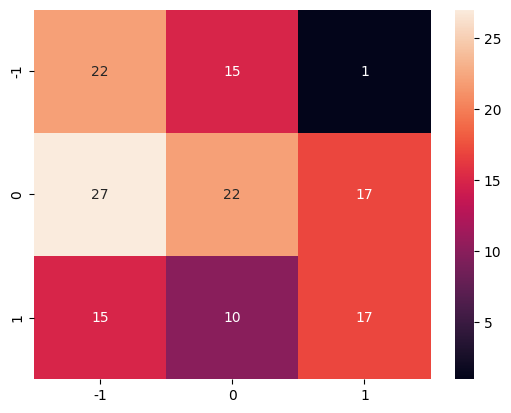

In [26]:
sns.heatmap(cm, annot=True, xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])

### Classification Report

In [27]:
cr = classification_report(y[split:], y_predict)
print(cr)

              precision    recall  f1-score   support

          -1       0.34      0.58      0.43        38
           0       0.47      0.33      0.39        66
           1       0.49      0.40      0.44        42

    accuracy                           0.42       146
   macro avg       0.43      0.44      0.42       146
weighted avg       0.44      0.42      0.42       146



In [28]:
df['cum_rets'] = (df['strategy_returns'][split:]+1).cumprod()
df['peak'] = df['cum_rets'].cummax()
df['drawdown'] = df['cum_rets'] - df['peak']
df['drawdown'].min()*100

-0.14169083433008822

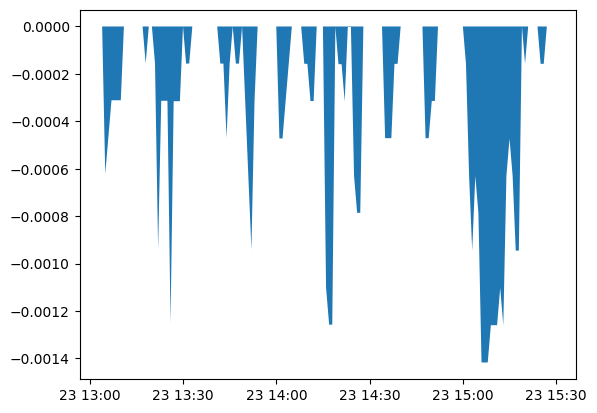

In [29]:
plt.fill_between(df['drawdown'].index, df['drawdown'].values)

### Aannualised Sharpe ratio

In [30]:
sharpe = np.sqrt(252*6.25*60) * df['strategy_returns'][split:].mean() / df['strategy_returns'][split:].std()

print("The annualised Sharpe ratio is %.2f" % sharpe)

The annualised Sharpe ratio is 77.74


### Plot the results

Now you can plot the results to visualise the performance.

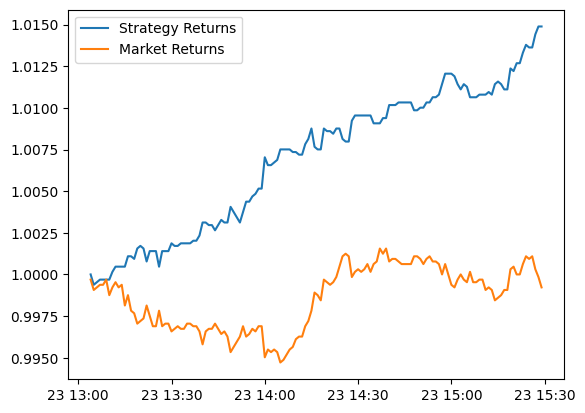

In [31]:
plt.plot((df['strategy_returns'][split:]+1).cumprod())
plt.plot((df['fut_rets'][split:]+1).cumprod())
plt.legend(labels=["Strategy Returns", "Market Returns"])



In [32]:
return_strategy = ((df['strategy_returns'][split:]+1).cumprod().tail(1)[0]-1)*100

print(f"The strategy return is {return_strategy:.2f}")

The strategy return is 1.49
